In [1]:
# Load in all preliminary Stuff
set.seed(1)
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.plot.width = 12, repr.plot.height = 12)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

# Heart Disease Classification
    By: Andy Hu, Sharon Tu, Dylan Zhang, Renz Tingson

## Introduction
When will we find the cure to cancer? What is the newest cutting edge medicine technology? Medicine is on the forefront of advancements, where people pour extensive resources into it for research purposes and progression. Especially, heart diseases have significant effects on patient health, some of which include heart attacks, heart failure, strokes, and angina. As such, it is crucial to be able to diagnose heart diseases before it is too late. Our research aims to find ways in which we can accomplish this.

## Research Question
What factors constitute to classifying whether or not a patient has a heart disease? We plan to classify if a patient has a heart disease (in other words, that they have >50% diameter narrowing of blood levels) based on a couple of predictors. 

## Dataset
We will be using the cleveland dataset for our research. The cleveland dataset contains 14 distinct characteristics about the patients, including age, sex, chest pain type, cholesterol levels, and many more. For each patient, they are simultaneously diagnosed with either not having heart disease(value of 0) or having heart disease(value of 1).

In [2]:
# Preliminary Exploratory Data Analysis 

## Loading the dataset into R, and cleaning/wrangling into a tidy format
vec_names <- c( "age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", "thalach", "exang", "oldpeak", "slope", "ca", "thal", "num" )

heart_data <- read_csv("data/cleveland_heart.txt", col_names = vec_names) |>
    mutate(across(sex:cp, as_factor)) |>
    mutate(across(fbs:restecg, as_factor)) |>
    mutate(exang = as_factor(exang)) |>
    mutate(across(slope:num, as_factor)) |>
    mutate(num = replace(num, num == 2 | num == 3 | num == 4, 1))

heart_data
write_csv(heart_data, "data/cleveland_data.csv")


Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): ca, thal
dbl (12): age, sex, cp, trestbps, chol, fbs, restecg, thalach, exang, oldpea...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
<dbl>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<fct>,<dbl>,<fct>,<dbl>,<fct>,<fct>,<fct>,<fct>
63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,1
67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0
56,1,2,120,236,0,0,178,0,0.8,1,0.0,3.0,0
62,0,4,140,268,0,2,160,0,3.6,3,2.0,3.0,1
57,0,4,120,354,0,0,163,1,0.6,1,0.0,3.0,0
63,1,4,130,254,0,2,147,0,1.4,2,1.0,7.0,1


num,count
<fct>,<int>
0,123
1,104


num,age,trestbps,chol,thalach
<fct>,<dbl>,<dbl>,<dbl>,<dbl>
0,52.96748,130.4553,243.9106,158.6748
1,57.23077,135.5096,250.5673,138.2308


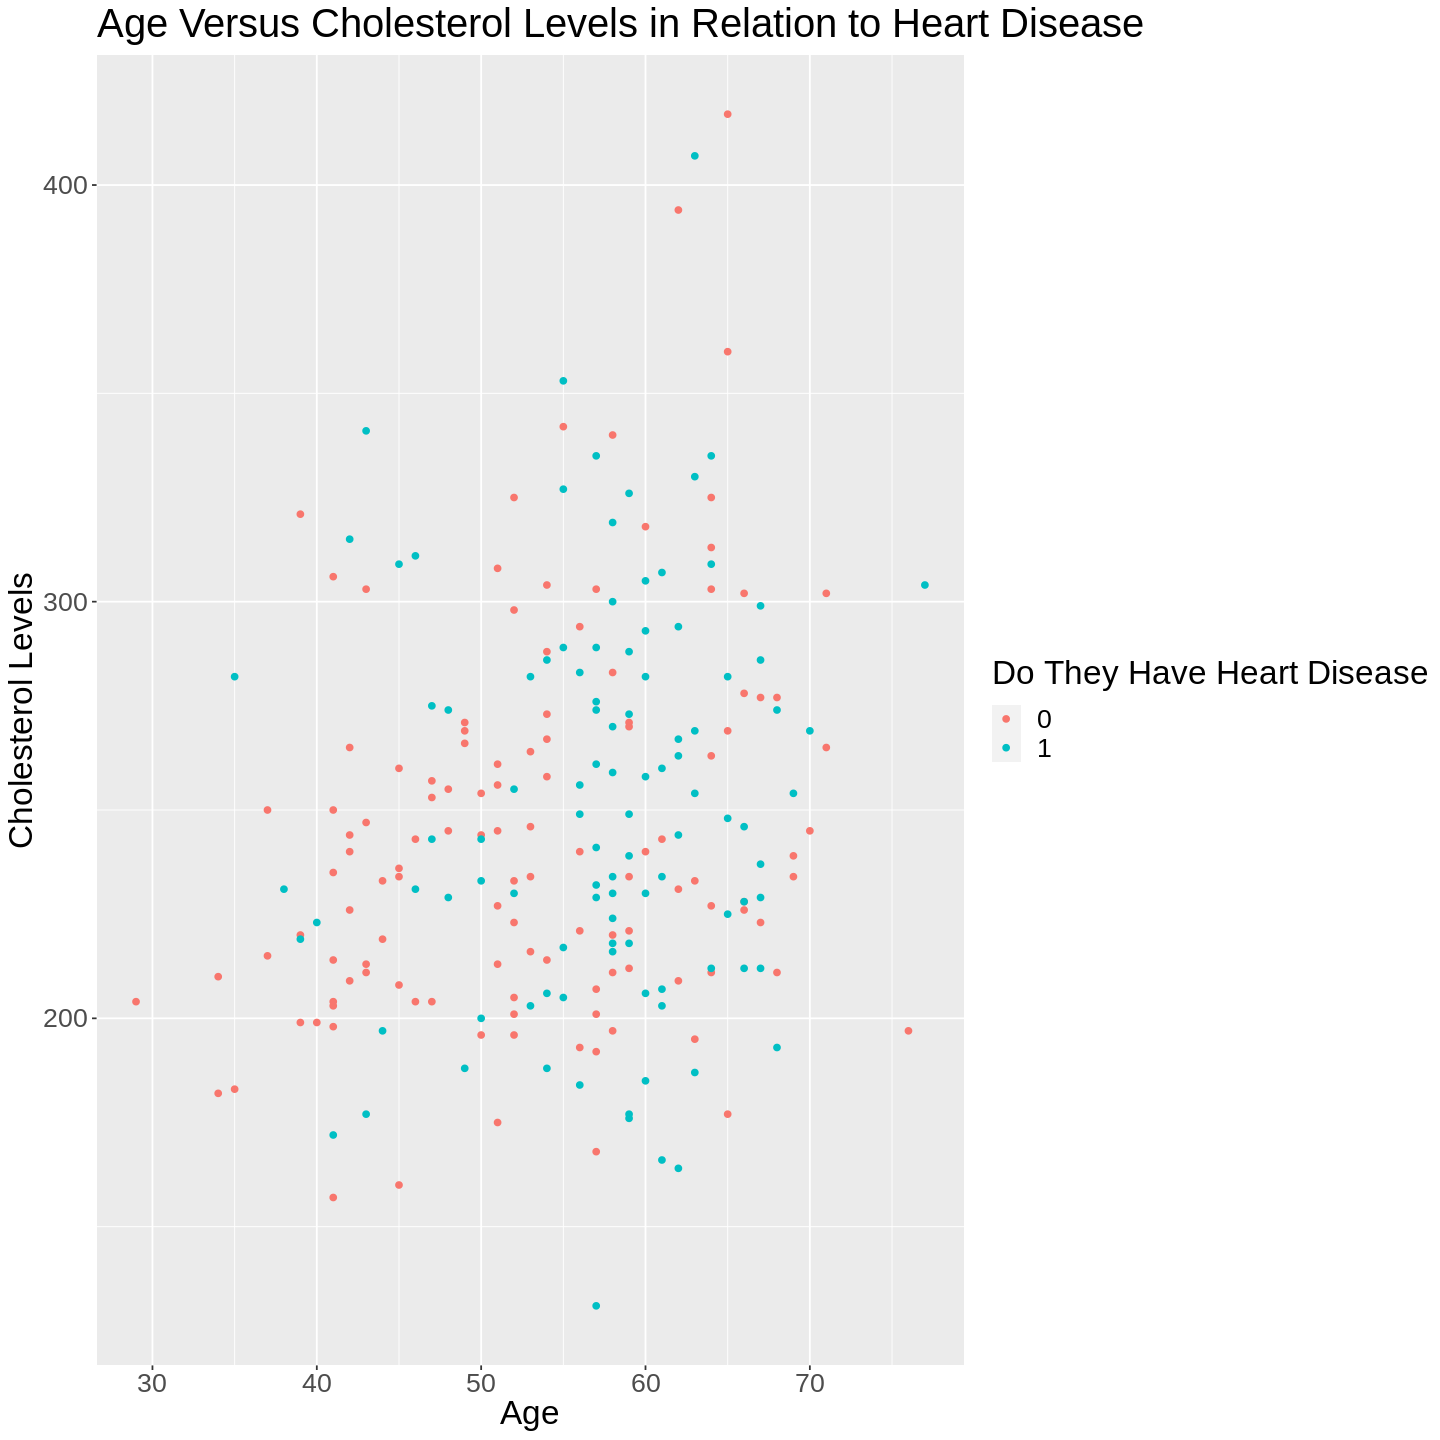

In [3]:
# Using only Training Data

heart_data_split <- initial_split(heart_data, prop = 0.75, strata = num)
heart_training <- training(heart_data_split)
heart_testing <- testing(heart_data_split)

## Summarize the data in at least one table. Eg. Report number of observations in each class,
## means of predictor variables you plan to use,

num_obs <- heart_training |>
    group_by(num) |>
    summarize(count = n())
num_obs

means <- heart_training |>
    select(age, trestbps, chol, thalach, num) |>
    group_by(num) |>
    summarize(across(age:thalach, mean))
means
    

## Visualize the data with at least one plot relevant to the analysis you plan to do. Compare the distribution
## of each of the predictor variables you plan to use

heart_plot <- heart_training |>
    ggplot(aes(x = age, y = chol, color = num)) +
    geom_point() +
    xlab("Age") +
    ylab("Cholesterol Levels") +
    labs(color = "Do They Have Heart Disease") +
    ggtitle("Age Versus Cholesterol Levels in Relation to Heart Disease") +
    theme(text = element_text(size = 20))
heart_plot

## Methods
To conduct our research on determining the factors that determine whether or not a patient has a heart disease, we will use the Cleveland dataset and split it into a train/test split, and further perfrom cross validation on our training data to tune for an optimal `k` value to use in a K-Nearest Neighbor algorithm for regression. We plan to use the following variables: age, resting heart rate, cholesterol levels, and maximum heart rate achieved. However, these predictors are subject to change should we discover other trends. Upon building a successful model, we will train our model once again with the tuned `k` value and compare its accuracy against the testing data, which includes the classification type of each of the patients that our model will try and predict.

## Visualization
We will visualize a graph comparing the RMSPE against the number of neighbors, thus solidfying our choice of `k` in the 'k'-nearest-neighbor algorithm. We also aim to visualize our predicted regression line over top of our data scattered in a scatter plot at the optimal value of `k` in a 2D plot. Should we include more predictors, we can do a multivariable KNN regression and visualize it in a 3D space. 

<!--

The best way to visualize our data would be to use a scatter plot, because we are comparing multiple continuous variables against each other, and we can colour the points by their classification of having a heart disease. Since we have so many potential predictors, visualizing this would require us to line up our visualizations side by side to show their effects. 

 ^ this is commented out btw. This is more like pre-processing stuff, not actually visualization for results with our actual model, so I think we shouldn't say this.

-->

## Expected Outcomes
We expect to find strong and quantifiable relationships between our chosen predictors and classification of whether or not a patient has a heart disease or not. We expect to see that higher measurements in our predictors will lead to a higher chance of classifying someone as having a heart disease. We expect that our model will be able to predict the classification of new patients with accuracy. 

## Significance
Such findings could have a great impact in reducing the amount of fatal heart disease problems. If someone can easily use our model to reliably predict if they are at risk of heart disease, they will have the ability go seek further medical attention from a specialist or doctor before it gets out of hand and terminal. The predictors we use are all easily monitorable factors that do not require much external equipment to measure, so it is readily accessible by everyone to self diagnose. 

## Future Questions
While finding a model to predict whether or not someone has a heart disease is great, there are still many restrictions and limitations involved with our research, which raises the awareness to further questions. For example, can our model become a mainsteram way for people to reliably test if they have a heart disease and seek more medical attention? Also, to ensure maximum accuracy of our model, we may conider adding other predictors that have a larger impact on the effects on heart disease, and potentially revise our current model to support these additions and possibly remove some less significant predictors. We also recognize the limitations of employing a KNN algorithm for regression, so other variations could be considered. 